In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [7]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count
0,2021-10-25,13271,Telfair County,GA,17.9,2845,21.0,3323.0
1,2021-10-25,18075,Jay County,IN,35.1,7165,38.2,7799.0
2,2021-10-25,26127,Oceana County,MI,49.7,13149,51.9,13727.0
3,2021-10-25,28161,Yalobusha County,MS,59.3,7175,66.5,8047.0
4,2021-10-25,30001,Beaverhead County,MT,49.0,4636,52.3,4940.0
...,...,...,...,...,...,...,...,...
1040397,2020-12-13,22061,Lincoln Parish,LA,0.0,0,0.0,0.0
1040398,2020-12-13,37127,Nash County,NC,0.0,0,0.0,0.0
1040399,2020-12-13,47185,White County,TN,0.0,0,0.0,0.0
1040400,2020-12-13,51043,Clarke County,VA,0.0,0,0.0,0.0


<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [8]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [9]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [10]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [11]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

,state,Date,short_staffed,got_covid_at_hosp,total_beds,beds_used,covid_beds_used,icu_occupancy,covid_icu,covid_beds_adult,covid_beds_kids,icu_total,beds_used_pct,covid_patients_pct,covid_beds_pct,icu_used,icu_used_pct,therapy_a,therapy_b,therapy_b
31257,NC,2020-01-01,0.0,0.0,72.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27888,PR,2020-01-01,0.0,0.0,146.0,61.0,0.0,NaN,NaN,NaN,NaN,NaN,0.417808,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
28031,MN,2020-01-01,0.0,0.0,46.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26544,LA,2020-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30816,IN,2020-01-01,0.0,0.0,30.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20557,LA,2021-10-25,54.0,3.0,12528.0,8690.0,288.0,1058.0,97.0,279.0,9.0,1532.0,0.693646,0.033551,0.023324,0.064796,0.690601,14153.0,2639.0,2306.0
13181,MD,2021-10-25,2.0,0.0,8168.0,6757.0,754.0,722.0,162.0,733.0,21.0,1053.0,0.827253,0.112689,0.093502,0.159606,0.685660,1109.0,666.0,1342.0
20383,TN,2021-10-25,24.0,29.0,18225.0,12749.0,1310.0,1626.0,394.0,1290.0,20.0,2395.0,0.701728,0.104435,0.073201,0.171156,0.681190,378.0,36.0,78.0
22350,TX,2021-10-25,7.0,60.0,60879.0,45405.0,4715.0,5853.0,1531.0,4570.0,145.0,6627.0,0.745824,0.105093,0.078434,0.236777,0.883205,811.0,102.0,446.0


<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [12]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.0
70.9


,level_0,index,Date,tier,population,total_vaccinated_count,first_dose_count,tot_confirm,tot_death,New_Cases,New_Deaths,case_7_day_avg,death_7_day_avg,case_avg_100k,death_avg_100k,total_vaccinated_percent,first_dose_pct
0,0,0,2020-12-28,total_40,9061156,0,0,610047,7757,7479,92,12295.142857,162.000000,135.690665,1.787851,0.000000,0.000000
1,1,0,2020-12-29,total_40,9061156,0,0,617024,7819,11271,147,12247.571429,164.500000,135.165661,1.815442,0.000000,0.000000
2,2,0,2020-12-30,total_40,9061156,0,0,625042,7900,14995,143,12320.785714,160.357143,135.973663,1.769721,0.000000,0.000000
3,3,0,2020-12-31,total_40,9061156,0,0,632046,8039,15022,220,12324.714286,157.714286,136.017019,1.740554,0.000000,0.000000
4,4,0,2021-01-01,total_40,9061156,0,0,639053,8107,14011,207,12128.357143,157.000000,133.849998,1.732671,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,296,0,2021-10-20,total_40,9061156,3913877,4660857,1459368,24012,7250,321,7155.714286,213.642857,78.971318,2.357788,0.431940,0.514378
297,297,0,2021-10-21,total_40,9061156,3918938,4665633,1463516,24084,7814,224,7035.500000,208.428571,77.644618,2.300243,0.432499,0.514905
298,298,0,2021-10-22,total_40,9061156,3927571,4675769,1468110,24193,8742,181,6979.357143,198.714286,77.025019,2.193035,0.433451,0.516023
299,299,0,2021-10-23,total_40,9061156,3935199,4682225,1470653,24231,7137,147,6938.071429,187.142857,76.569385,2.065331,0.434293,0.516736


- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [13]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [1, 16, 54, 56], 'state': ['AL', 'ID', 'WV', 'WY']}, 45: {'FIPS': [5, 13, 18, 22, 28, 29, 38, 40, 45, 47], 'state': ['AR', 'GA', 'IN', 'LA', 'MS', 'MO', 'ND', 'OK', 'SC', 'TN']}, 50: {'FIPS': [4, 17, 20, 21, 26, 30, 32, 37, 39, 46, 48, 49], 'state': ['AZ', 'IL', 'KS', 'KY', 'MI', 'MT', 'NV', 'NC', 'OH', 'SD', 'TX', 'UT']}, 55: {'FIPS': [10, 12, 19, 27, 31, 55], 'state': ['DE', 'FL', 'IA', 'MN', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 33, 41, 42, 51, 53], 'state': ['CA', 'CO', 'NH', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 25, 34, 35, 36], 'state': ['MD', 'MA', 'NJ', 'NM', 'NY']}, 70: {'FIPS': [9, 23, 44, 50], 'state': ['CT', 'ME', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


,population,Date,tot_death,tot_confirm,New_Cases,New_Deaths,case_7_day_avg,case_avg_100k,death_7_day_avg,death_avg_100k,loc,FIPS,tier,total_beds,beds_used,covid_beds_used,icu_total,icu_used,covid_icu,covid_beds_adult,covid_beds_kids,case_scaled_100k,death_scaled_100k
16,9061156,2020-02-07,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,9061156,2020-02-08,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,9061156,2020-02-09,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,9061156,2020-02-10,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,9061156,2020-02-11,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,6592849,2021-10-20,13020,713895,3330,25,2970.857143,45.061811,23.000000,0.348863,CT,"[9, 23, 44, 50]",total_70,15435.0,12533.0,633.0,1623.0,0.570028330862422,176.0,620.0,13.0,45.061811,0.348863
3848,6592849,2021-10-21,13026,715474,2957,20,2832.000000,42.955633,16.142857,0.244854,CT,"[9, 23, 44, 50]",total_70,15434.0,12534.0,607.0,1621.0,0.5668881478873999,179.0,597.0,10.0,42.955633,0.244854
3849,6592849,2021-10-22,13050,716926,3031,30,2728.142857,41.380333,16.428571,0.249188,CT,"[9, 23, 44, 50]",total_70,15496.0,12529.0,620.0,1623.0,0.47340619317060795,157.0,609.0,11.0,41.380333,0.249188
3850,6592849,2021-10-23,13057,717764,2290,31,2703.857143,41.011968,17.571429,0.266523,CT,"[9, 23, 44, 50]",total_70,15501.0,12448.0,621.0,1622.0,0.5021203794965831,164.0,610.0,11.0,41.011968,0.266523


<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [14]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count,tier
334,2020-12-21,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,1097540,18578,17723,116,24705.714286,305.428571,126.338103,1.561876,100,1.561876,0.0,0,0.0,0.0,total_30
335,2020-12-22,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,1112347,18799,22483,271,24824.714286,305.428571,126.946636,1.561876,100,1.561876,0.0,0,0.0,0.0,total_30
336,2020-12-23,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,1126058,19026,28518,448,24979.000000,310.142857,127.73561,1.585984,100,1.585984,0.0,0,0.0,0.0,total_30
337,2020-12-24,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,1141397,19220,29050,421,25108.285714,309.142857,128.396741,1.58087,100,1.58087,0.0,0,0.0,0.0,total_30
338,2020-12-25,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,1149727,19330,23669,304,24199.285714,302.571429,123.74837,1.547266,100,1.547266,0.0,0,0.0,0.0,total_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2021-10-20,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2866562,47276,7351,160,6896.142857,87.428571,27.353662,0.346787,27.353662,0.346787,72.067627,18168999,80.323676,20250435.0,total_70
638,2021-10-21,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2869998,47317,6809,89,6829.428571,82.142857,27.089038,0.325821,27.089038,0.325821,72.130611,18184878,80.390496,20267281.0,total_70
639,2021-10-22,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2875075,47362,8513,86,6610.714286,83.857143,26.221505,0.332621,26.221505,0.332621,73.078105,18423751,81.552694,20560283.0,total_70
640,2021-10-23,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2876307,47370,6309,53,6440.857143,87.857143,25.547764,0.348487,25.547764,0.348487,73.150173,18441920,81.633376,20580624.0,total_70


In [15]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
16,2020-02-07,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
17,2020-02-08,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
18,2020-02-09,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
19,2020-02-10,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2021-10-20,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2866562,47276,7351,160,6896.142857,87.428571,27.353662,0.346787,27.353662,0.346787,total_70
638,2021-10-21,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2869998,47317,6809,89,6829.428571,82.142857,27.089038,0.325821,27.089038,0.325821,total_70
639,2021-10-22,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2875075,47362,8513,86,6610.714286,83.857143,26.221505,0.332621,26.221505,0.332621,total_70
640,2021-10-23,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2876307,47370,6309,53,6440.857143,87.857143,25.547764,0.348487,25.547764,0.348487,total_70


In [16]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
16,2020-02-07,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
17,2020-02-08,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
18,2020-02-09,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
19,2020-02-10,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2021-10-20,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,7669976,102357,30311,745,28363.571429,467.857143,52.428168,0.864803,52.428168,0.864803,total_50
638,2021-10-21,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,7682940,102601,29867,776,27161.857143,462.428571,50.20688,0.854768,50.20688,0.854768,total_50
639,2021-10-22,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,7702247,102889,32271,532,26556.571429,468.857143,49.088049,0.866651,49.088049,0.866651,total_50
640,2021-10-23,"[19197, 18089, 42021, 36017, 17015, 48209, 460...",Hale,Alabama,"Hale, Alabama, US",54099871,7706044,102933,23104,332,26019.142857,471.285714,48.094649,0.87114,48.094649,0.87114,total_50


- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [17]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
           Date                                               FIPS Admin2 Province_State       Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  death_7_day_avg  \
15   2020-02-06  [50011, 8039, 48233, 47153, 17047, 42105, 4716...   Bibb        Alabama  Bibb, Alabama, US   19555236           0          0           0          0        0.000000         0.000000   
16   2020-02-07  [50011, 8039, 48233, 47153, 17047, 42105, 4716...   Bibb        Alabama  Bibb, Alabama, US   19555236           0          0           0          0        0.000000         0.000000   
17   2020-02-08  [50011, 8039, 48233, 47153, 17047, 42105, 4716...   Bibb        Alabama  Bibb, Alabama, US   19555236           0          0           0          0        0.000000         0.000000   
18   2020-02-09  [50011, 8039, 48233, 47153, 17047, 42105, 4716...   Bibb        Alabama  Bibb, Alabama, US   19555236           0          0           0          0        0.

           Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [19115, 19097, 6071, 36035, 18013, 39069, 3915...  Clarke        Alabama  Clarke, Alabama, US   42703507           1          0           0          0        0.000000   
16   2020-02-07  [19115, 19097, 6071, 36035, 18013, 39069, 3915...  Clarke        Alabama  Clarke, Alabama, US   42703507           1          0           0          0        0.000000   
17   2020-02-08  [19115, 19097, 6071, 36035, 18013, 39069, 3915...  Clarke        Alabama  Clarke, Alabama, US   42703507           1          0           0          0        0.000000   
18   2020-02-09  [19115, 19097, 6071, 36035, 18013, 39069, 3915...  Clarke        Alabama  Clarke, Alabama, US   42703507           1          0           0          0        0.000000   
19   2020-02-10  [19115, 19097, 6071, 36035, 18013, 39069, 3915..

           Date                                               FIPS    Admin2 Province_State           Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [20091, 51013, 26161, 24047, 36021, 42053, 410...  Coconino        Arizona  Coconino, Arizona, US   19995896           0          0           0          0        0.000000   
16   2020-02-07  [20091, 51013, 26161, 24047, 36021, 42053, 410...  Coconino        Arizona  Coconino, Arizona, US   19995896           0          0           0          0        0.000000   
17   2020-02-08  [20091, 51013, 26161, 24047, 36021, 42053, 410...  Coconino        Arizona  Coconino, Arizona, US   19995896           0          0           0          0        0.000000   
18   2020-02-09  [20091, 51013, 26161, 24047, 36021, 42053, 410...  Coconino        Arizona  Coconino, Arizona, US   19995896           0          0           0          0        0.000000   
19   2020-02-10  [20091, 51013, 26161, 24047,

           Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
526  2021-07-01  [19115, 19097, 6071, 36035, 18013, 39069, 3915...  Clarke        Alabama  Clarke, Alabama, US   42703507     4644041      82894        5683        133     4378.857143   
527  2021-07-02  [19115, 19097, 6071, 36035, 18013, 39069, 3915...  Clarke        Alabama  Clarke, Alabama, US   42703507     4646866      82955        5303        130     4414.571429   
528  2021-07-03  [19115, 19097, 6071, 36035, 18013, 39069, 3915...  Clarke        Alabama  Clarke, Alabama, US   42703507     4647745      82970        3704         76     4419.428571   
529  2021-07-04  [19115, 19097, 6071, 36035, 18013, 39069, 3915...  Clarke        Alabama  Clarke, Alabama, US   42703507     4648435      82977        1569         22     4399.000000   
530  2021-07-05  [19115, 19097, 6071, 36035, 18013, 39069, 3915..

           Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
526  2021-07-01  [8079, 23023, 42093, 36061, 4001, 8014, 30087,...  Apache        Arizona  Apache, Arizona, US   25211041     2297931      45167        1353         14     1346.571429   
527  2021-07-02  [8079, 23023, 42093, 36061, 4001, 8014, 30087,...  Apache        Arizona  Apache, Arizona, US   25211041     2301565      45173        4338         17     1512.285714   
528  2021-07-03  [8079, 23023, 42093, 36061, 4001, 8014, 30087,...  Apache        Arizona  Apache, Arizona, US   25211041     2301730      45174        3799          7     1601.000000   
529  2021-07-04  [8079, 23023, 42093, 36061, 4001, 8014, 30087,...  Apache        Arizona  Apache, Arizona, US   25211041     2301920      45177         355          4     1525.857143   
530  2021-07-05  [8079, 23023, 42093, 36061, 4001, 8014, 30087,..

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,19555236,0.059986,2020-02-06,2021-06-30,2002662,10241.052575,38750,198.156647
1,0,total_35,start,17799925,0.054601,2020-02-06,2021-06-30,1948923,10949.051752,37423,210.242459
2,0,total_40,start,25634711,0.078635,2020-02-06,2021-06-30,2718249,10603.782504,49490,193.058545
3,0,total_45,start,42703507,0.130993,2020-02-06,2021-06-30,4641562,10869.275912,82825,193.953625
4,0,total_50,start,54099871,0.165951,2020-02-06,2021-06-30,5578444,10311.381334,85585,158.198159
5,0,total_55,start,63144214,0.193695,2020-02-06,2021-06-30,6132688,9712.193108,105535,167.133286
6,0,total_60,start,57853783,0.177467,2020-02-06,2021-06-30,5852554,10116.112891,110229,190.530324
7,0,total_65,start,19995896,0.061337,2020-02-06,2021-06-30,1959308,9798.550663,39032,195.200055
8,0,total_70,start,25211041,0.077335,2020-02-06,2021-06-30,2297224,9111.975979,45156,179.112001


In [18]:
start_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,19555236,0.059986,2020-02-06,2021-06-30,2002662,10241.052575,38750,198.156647
1,0,total_35,start,17799925,0.054601,2020-02-06,2021-06-30,1948923,10949.051752,37423,210.242459
2,0,total_40,start,25634711,0.078635,2020-02-06,2021-06-30,2718249,10603.782504,49490,193.058545
3,0,total_45,start,42703507,0.130993,2020-02-06,2021-06-30,4641562,10869.275912,82825,193.953625
4,0,total_50,start,54099871,0.165951,2020-02-06,2021-06-30,5578444,10311.381334,85585,158.198159
5,0,total_55,start,63144214,0.193695,2020-02-06,2021-06-30,6132688,9712.193108,105535,167.133286
6,0,total_60,start,57853783,0.177467,2020-02-06,2021-06-30,5852554,10116.112891,110229,190.530324
7,0,total_65,start,19995896,0.061337,2020-02-06,2021-06-30,1959308,9798.550663,39032,195.200055
8,0,total_70,start,25211041,0.077335,2020-02-06,2021-06-30,2297224,9111.975979,45156,179.112001


In [19]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count
188,2021-10-25,35031,McKinley County,NM,99.9,72336,99.9,80262.0
4287,2021-10-24,35031,McKinley County,NM,99.9,72289,99.9,80176.0
6612,2021-10-23,35031,McKinley County,NM,99.9,72213,99.9,80055.0
10136,2021-10-22,35031,McKinley County,NM,99.9,72140,99.9,79946.0
13212,2021-10-21,35031,McKinley County,NM,99.9,72020,99.9,79747.0
...,...,...,...,...,...,...,...,...
1026232,2020-12-17,35031,McKinley County,NM,0.0,0,0.0,0.0
1027455,2020-12-16,35031,McKinley County,NM,0.0,0,0.0,0.0
1032081,2020-12-15,35031,McKinley County,NM,0.0,0,0.0,0.0
1035229,2020-12-14,35031,McKinley County,NM,0.0,0,0.0,0.0


# Build Statewide Overview Summary Dictionary #

In [20]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-24 00:00:00'),
  'confirm_period': 861904,
  'confirm_start': 610047,
  'confirm_end': 1471951,
  'confirm_period_100k': 9512.075501183293,
  'confirm_deaths': 16475,
  'death_period_100k': 181.82006799132472,
  'vax_complete': 3938710,
  'vax_complete_100k': 43468.074051478645,
  'vax_partial': 4685406,
  'vax_partial_100k': 51708.700302698686,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 50826738,
  'pop_pct': 0.15534864723264338,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-24 00:00:00'),
  'confirm_period': 4642609,
  'confirm_start': 3495089,
  'confirm_end': 8137698,
  'confirm_period_100k': 9134.186419754107,
  'confirm_deaths': 75174,
  'death_period_100k': 147.9024681851509,
  'vax_complete': 24502435,
  'vax_complete_100k': 48207.7661564667,

# Statewide Vax Tier Graphs #

In [21]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0277 confirm 100k:9512 Death 100k:181 Vaccine 100k:43468
total_45 pop pct:0.1553 confirm 100k:9134 Death 100k:147 Vaccine 100k:48207
total_50 pop pct:0.2957 confirm 100k:7896 Death 100k:119 Vaccine 100k:52943
total_55 pop pct:0.1192 confirm 100k:9021 Death 100k:71 Vaccine 100k:58677
total_60 pop pct:0.2494 confirm 100k:6707 Death 100k:106 Vaccine 100k:60802
total_65 pop pct:0.1527 confirm 100k:7187 Death 100k:95 Vaccine 100k:67043


# Build Statewide Overview Summer Summary Dictionary #

In [22]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-24 00:00:00'),
  'confirm_period': 793378,
  'confirm_start': 678573,
  'confirm_end': 1471951,
  'confirm_period_100k': 8755.814379533915,
  'confirm_deaths': 15628,
  'death_period_100k': 172.4724748144718,
  'vax_complete': 3938710,
  'vax_complete_100k': 43468.074051478645,
  'vax_partial': 4685406,
  'vax_partial_100k': 51708.700302698686,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 50826738,
  'pop_pct': 0.15534864723264338,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-24 00:00:00'),
  'confirm_period': 4236902,
  'confirm_start': 3900796,
  'confirm_end': 8137698,
  'confirm_period_100k': 8335.970724700059,
  'confirm_deaths': 70126,
  'death_period_100k': 137.9706877903516,
  'vax_complete': 24502435,
  'vax_complete_100k': 48207.7661564667,


# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [23]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

,tier,period,population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,total_40,start,9061156,0.027847,2020-02-07,2021-06-30,972312,10730.551378,17142,189.181160
0,total_45,start,50826738,0.156204,2020-02-07,2021-06-30,5653753,11123.580270,99229,195.229920
0,total_50,start,96730998,0.297280,2020-02-07,2021-06-30,10054260,10394.041422,171684,177.486022
0,total_55,start,39003045,0.119867,2020-02-07,2021-06-30,4356544,11169.753541,62757,160.902822
0,total_60,start,79800808,0.245249,2020-02-07,2021-06-30,7086799,8880.610582,119120,149.271672
0,total_65,start,43370763,0.133290,2020-02-07,2021-06-30,4513233,10406.164632,111952,258.127808
0,total_70,start,6592849,0.020262,2020-02-07,2021-06-30,595409,9031.133581,12111,183.699035
0,total_40,summer,9061156,0.027847,2021-07-01,2021-10-24,499429,5511.758102,7082,78.157798
0,total_45,summer,50826738,0.156204,2021-07-01,2021-10-24,2479626,4878.585755,31288,61.558151
0,total_50,summer,96730998,0.297280,2021-07-01,2021-10-24,3506178,3624.668485,39615,40.953780


In [24]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10241.052575
1    10949.051752
2    10603.782504
3    10869.275912
4    10311.381334
5     9712.193108
6    10116.112891
7     9798.550663
8     9111.975979
Name: confirm_period_100k, dtype: float64
9     4768.196098
10    5173.010560
11    4869.717470
12    3969.854279
13    3933.502910
14    3140.406499
15    2666.676093
16    2003.496117
17    2296.339132
Name: confirm_period_100k, dtype: float64
0    0.465596
1    0.472462
2    0.459243
3    0.365236
4    0.381472
5    0.323347
6    0.263607
7    0.204469
8    0.252013
dtype: float64
0    0.346890
1    0.328434
2    0.309719
3    0.225463
4    0.202255
5    0.139935
6    0.097778
7    0.068021
8    0.048853
dtype: float64



In [25]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [26]:
county_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,19555236,0.060099,2020-02-06,2021-06-30,2002662,10241.052575,38750,198.156647
1,0,total_35,start,17799925,0.054704,2020-02-06,2021-06-30,1948923,10949.051752,37423,210.242459
2,0,total_40,start,25634711,0.078782,2020-02-06,2021-06-30,2718249,10603.782504,49490,193.058545
3,0,total_45,start,42703507,0.131239,2020-02-06,2021-06-30,4641562,10869.275912,82825,193.953625
4,0,total_50,start,54099871,0.166263,2020-02-06,2021-06-30,5578444,10311.381334,85585,158.198159
5,0,total_55,start,63144214,0.194059,2020-02-06,2021-06-30,6132688,9712.193108,105535,167.133286
6,0,total_60,start,57853783,0.177800,2020-02-06,2021-06-30,5852554,10116.112891,110229,190.530324
7,0,total_65,start,19995896,0.061453,2020-02-06,2021-06-30,1959308,9798.550663,39032,195.200055
8,0,total_70,start,25211041,0.077480,2020-02-06,2021-06-30,2297224,9111.975979,45156,179.112001
9,0,total_30,summer,19555236,0.060099,2021-07-01,2021-10-24,932432,4768.196098,13442,68.738623


In [27]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
314        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
313        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
312        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
311        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
310        1      1  Alabama  POLYGON ((-88.46866 31.89

- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

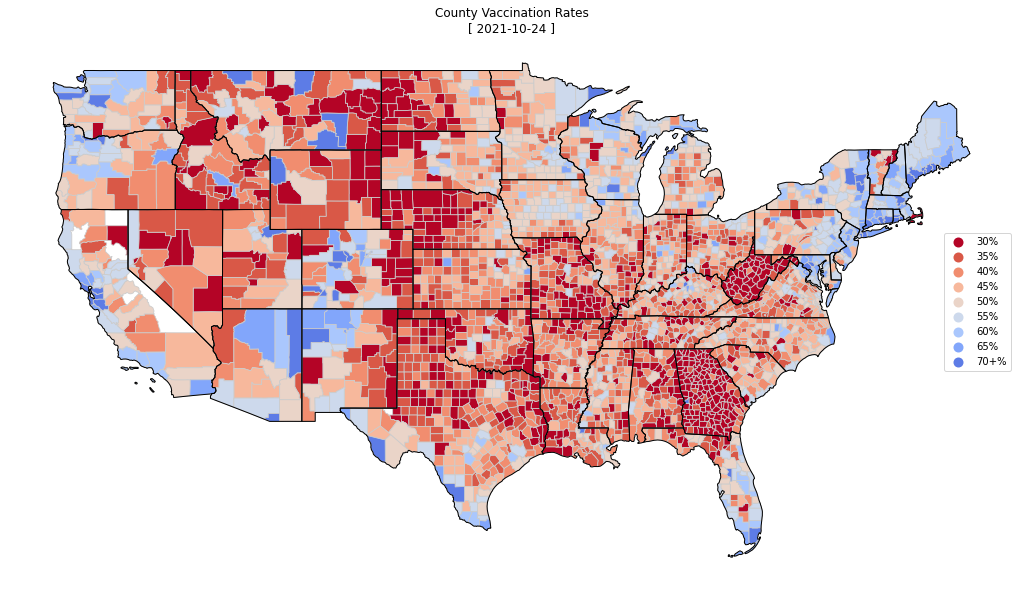

In [28]:
plot_df = geo_county_tier_df.copy()



#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


#outfilename=f'z_blog_natl_county_vax.jpg'
#out_blog_images.append(outfilename)
#fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")





In [29]:
start_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,19555236,0.060099,2020-02-06,2021-06-30,2002662,10241.052575,38750,198.156647
1,0,total_35,start,17799925,0.054704,2020-02-06,2021-06-30,1948923,10949.051752,37423,210.242459
2,0,total_40,start,25634711,0.078782,2020-02-06,2021-06-30,2718249,10603.782504,49490,193.058545
3,0,total_45,start,42703507,0.131239,2020-02-06,2021-06-30,4641562,10869.275912,82825,193.953625
4,0,total_50,start,54099871,0.166263,2020-02-06,2021-06-30,5578444,10311.381334,85585,158.198159
5,0,total_55,start,63144214,0.194059,2020-02-06,2021-06-30,6132688,9712.193108,105535,167.133286
6,0,total_60,start,57853783,0.177800,2020-02-06,2021-06-30,5852554,10116.112891,110229,190.530324
7,0,total_65,start,19995896,0.061453,2020-02-06,2021-06-30,1959308,9798.550663,39032,195.200055
8,0,total_70,start,25211041,0.077480,2020-02-06,2021-06-30,2297224,9111.975979,45156,179.112001


In [30]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 115


{'start_daily_100k_confirm': 0    10241
 1    10949
 2    10603
 3    10869
 4    10311
 5     9712
 6    10116
 7     9798
 8     9111
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9111,
 'start_daily_100k_confirm_max': 10949,
 'start_daily_mean_confirm': 0     3919.103718
 1     3813.939335
 2     5319.469667
 3     9083.291585
 4    10916.720157
 5    12001.346380
 6    11453.138943
 7     3834.262231
 8     4495.545988
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      8108.104348
 10     8006.886957
 11    10855.113043
 12    14741.452174
 13    18504.521739
 14    17243.347826
 15    13415.417391
 16     3483.626087
 17     5034.182609
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     75.831703
 1     73.234834
 2     96.849315
 3    162.084149
 4    167.485323
 5    206.526419
 6    215.712329
 7     76.383562
 8     88.367906
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     116.8

In [31]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10241
 1    10949
 2    10603
 3    10869
 4    10311
 5     9712
 6    10116
 7     9798
 8     9111
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9111,
 'start_daily_100k_confirm_max': 10949,
 'start_daily_mean_confirm': 0     3919.103718
 1     3813.939335
 2     5319.469667
 3     9083.291585
 4    10916.720157
 5    12001.346380
 6    11453.138943
 7     3834.262231
 8     4495.545988
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      8108.104348
 10     8006.886957
 11    10855.113043
 12    14741.452174
 13    18504.521739
 14    17243.347826
 15    13415.417391
 16     3483.626087
 17     5034.182609
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     75.831703
 1     73.234834
 2     96.849315
 3    162.084149
 4    167.485323
 5    206.526419
 6    215.712329
 7     76.383562
 8     88.367906
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     116.8

In [32]:
state_hosp_tiers_df

,population,Date,tot_death,tot_confirm,New_Cases,New_Deaths,case_7_day_avg,case_avg_100k,death_7_day_avg,death_avg_100k,loc,FIPS,tier,total_beds,beds_used,covid_beds_used,icu_total,icu_used,covid_icu,covid_beds_adult,covid_beds_kids,case_scaled_100k,death_scaled_100k
16,9061156,2020-02-07,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,9061156,2020-02-08,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,9061156,2020-02-09,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,9061156,2020-02-10,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,9061156,2020-02-11,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,6592849,2021-10-20,13020,713895,3330,25,2970.857143,45.061811,23.000000,0.348863,CT,"[9, 23, 44, 50]",total_70,15435.0,12533.0,633.0,1623.0,0.570028330862422,176.0,620.0,13.0,45.061811,0.348863
3848,6592849,2021-10-21,13026,715474,2957,20,2832.000000,42.955633,16.142857,0.244854,CT,"[9, 23, 44, 50]",total_70,15434.0,12534.0,607.0,1621.0,0.5668881478873999,179.0,597.0,10.0,42.955633,0.244854
3849,6592849,2021-10-22,13050,716926,3031,30,2728.142857,41.380333,16.428571,0.249188,CT,"[9, 23, 44, 50]",total_70,15496.0,12529.0,620.0,1623.0,0.47340619317060795,157.0,609.0,11.0,41.380333,0.249188
3850,6592849,2021-10-23,13057,717764,2290,31,2703.857143,41.011968,17.571429,0.266523,CT,"[9, 23, 44, 50]",total_70,15501.0,12448.0,621.0,1622.0,0.5021203794965831,164.0,610.0,11.0,41.011968,0.266523


In [33]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

,Date,Location,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_12PlusPop_Pct,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_18PlusPop_Pct,Administered_Dose1_Recip_65Plus,Administered_Dose1_Recip_65PlusPop_Pct,Series_Complete_Yes,Series_Complete_Pop_Pct,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct
20188,2020-12-13,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20182,2020-12-14,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20081,2020-12-15,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20034,2020-12-16,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20004,2020-12-17,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2021-10-21,US,219624445,66.2,219390343,77.4,204534420,79.2,52509902,96.0,189924447,57.2,189791361,66.9,177453836,68.7,46229324,84.5
226,2021-10-22,US,219900525,66.2,219666287,77.5,204788212,79.3,52572844,96.1,190179553,57.3,190046408,67.0,177683586,68.8,46264299,84.6
157,2021-10-23,US,220145796,66.3,219911449,77.6,205012732,79.4,52627847,96.2,190402262,57.4,190269066,67.1,177883133,68.9,46294318,84.6
113,2021-10-24,US,220351217,66.4,220116796,77.6,205201180,79.5,52678218,96.3,190578704,57.4,190445478,67.2,178039457,68.9,46318073,84.7


- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [34]:
"""#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False

if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                continue

                
        fig, ax = plt.subplots()

        fig.set_size_inches(10,5)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 70})

        plt.close()
        
    
    

    print("Done...")
"""
print()

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [108]:
start_summer_date =  datetime(2021, 7, 1).date()

county_daily_df = pd.read_pickle(county_daily_df_filename)
county_vax_df
county_daily_df = county_daily_df[county_daily_df['Population'] > 0]
county_daily_df
county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]


td = {
    'base_cols' : ["Date","tier","Population","tot_confirm","New_Confirm","case_100k_avg","death_100k_avg"],
    
    'tiers' : list(whole_county_tier_df['tier'].unique()),
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []



start_period_date = start_avg_daily_county_tier_df['Date'].min()

for date in start_avg_daily_county_tier_df['Date'].unique():
    if date >= start_summer_date:
        break
    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    
    
    days = (date - start_period_date).days + 1
    
    base_vals = {}
    for col in td['base_cols']:
        base_vals[col] = loop_df[col].iloc[-1]
    for tier in td['tiers']:
        
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = loop_df[loop_df['tier'] == tier][col].values[0]
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                td[col].append(tot_confirm)
                continue
            if col == "New_Confirm":
                new_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                td[col].append(new_confirm)
                continue
            if col == "case_100k_avg":
                case_100k_avg = tot_confirm / (pop / 100000)
                td[col].append(case_100k_avg)
                print(date,tier,pop,tot_confirm,case_100k_avg,days)
    print()  
        
        #pop = pop /100000
        #confirm = loop_df[loop_df['tier'] == tier]['tot_confirm'].values[0]
        #confirm_avg_daily_100k = confirm / pop
        #print(base_vals,tier,pop,confirm,confirm_avg_daily_100k)
            

2020-02-06 total_30 19555236 0 0.0 1
2020-02-06 total_35 17799925 0 0.0 1
2020-02-06 total_40 25634711 0 0.0 1
2020-02-06 total_45 42703507 1 0.0023417280458956215 1
2020-02-06 total_50 54099871 0 0.0 1
2020-02-06 total_55 63144214 4 0.006334705504450495 1
2020-02-06 total_60 57853783 4 0.006913981752930487 1
2020-02-06 total_65 19995896 0 0.0 1
2020-02-06 total_70 25211041 3 0.011899548297113158 1

2020-02-07 total_30 19555236 0 0.0 2
2020-02-07 total_35 17799925 0 0.0 2
2020-02-07 total_40 25634711 0 0.0 2
2020-02-07 total_45 42703507 1 0.0023417280458956215 2
2020-02-07 total_50 54099871 0 0.0 2
2020-02-07 total_55 63144214 4 0.006334705504450495 2
2020-02-07 total_60 57853783 4 0.006913981752930487 2
2020-02-07 total_65 19995896 0 0.0 2
2020-02-07 total_70 25211041 3 0.011899548297113158 2

2020-02-08 total_30 19555236 0 0.0 3
2020-02-08 total_35 17799925 0 0.0 3
2020-02-08 total_40 25634711 0 0.0 3
2020-02-08 total_45 42703507 1 0.0023417280458956215 3
2020-02-08 total_50 54099871

2020-03-04 total_30 19555236 2 0.010227439852937597 28
2020-03-04 total_35 17799925 1 0.005618001199443256 28
2020-03-04 total_40 25634711 0 0.0 28
2020-03-04 total_45 42703507 5 0.011708640229478108 28
2020-03-04 total_50 54099871 9 0.016635899187264238 28
2020-03-04 total_55 63144214 8 0.01266941100890099 28
2020-03-04 total_60 57853783 25 0.043212385955815544 28
2020-03-04 total_65 19995896 17 0.08501744557983298 28
2020-03-04 total_70 25211041 46 0.18245974055573508 28

2020-03-05 total_30 19555236 2 0.010227439852937597 29
2020-03-05 total_35 17799925 1 0.005618001199443256 29
2020-03-05 total_40 25634711 1 0.0039009606934909467 29
2020-03-05 total_45 42703507 7 0.01639209632126935 29
2020-03-05 total_50 54099871 11 0.020332765673322956 29
2020-03-05 total_55 63144214 14 0.022171469265576733 29
2020-03-05 total_60 57853783 42 0.07259680840577011 29
2020-03-05 total_65 19995896 30 0.15003078631735234 29
2020-03-05 total_70 25211041 76 0.30145522352686666 29

2020-03-06 total_30 195

2020-03-31 total_60 57853783 41416 71.58736706984226 55
2020-03-31 total_65 19995896 29155 145.80491916941358 55
2020-03-31 total_70 25211041 41723 165.49495120015075 55

2020-04-01 total_30 19555236 5347 27.343060446828666 56
2020-04-01 total_35 17799925 2743 15.410177290072852 56
2020-04-01 total_40 25634711 4245 16.559578143869068 56
2020-04-01 total_45 42703507 14867 34.8144708583302 56
2020-04-01 total_50 54099871 13514 24.979726846298767 56
2020-04-01 total_55 63144214 45604 72.2219774562401 56
2020-04-01 total_60 57853783 49381 85.35483323536509 56
2020-04-01 total_65 19995896 32862 164.34372333202774 56
2020-04-01 total_70 25211041 47602 188.8140993463935 56

2020-04-02 total_30 19555236 6000 30.682319558812793 57
2020-04-02 total_35 17799925 3303 18.556257961761077 57
2020-04-02 total_40 25634711 5101 19.89880049749732 57
2020-04-02 total_45 42703507 17473 40.917014145934196 57
2020-04-02 total_50 54099871 16202 29.948315403561686 57
2020-04-02 total_55 63144214 52459 83.07807

2020-04-28 total_55 63144214 214359 339.4752843071259 83
2020-04-28 total_60 57853783 248162 428.9468849426839 83
2020-04-28 total_65 19995896 149839 749.3487663668585 83
2020-04-28 total_70 25211041 170924 677.9727977119231 83

2020-04-29 total_30 19555236 32585 166.6305638039858 84
2020-04-29 total_35 17799925 21522 120.91062181441777 84
2020-04-29 total_40 25634711 33680 131.38435615677508 84
2020-04-29 total_45 42703507 76522 179.19371352802474 84
2020-04-29 total_50 54099871 76056 140.58443873184098 84
2020-04-29 total_55 63144214 219954 348.33595363147606 84
2020-04-29 total_60 57853783 255401 441.4594634200498 84
2020-04-29 total_65 19995896 152972 765.0169814846007 84
2020-04-29 total_70 25211041 173089 686.5603050663398 84

2020-04-30 total_30 19555236 33586 171.74939745038108 85
2020-04-30 total_35 17799925 22706 127.56233523455857 85
2020-04-30 total_40 25634711 35013 136.58433676119853 85
2020-04-30 total_45 42703507 79012 185.02461636230484 85
2020-04-30 total_50 54099871 

2020-05-26 total_65 19995896 213197 1066.2037850166855 111
2020-05-26 total_70 25211041 226824 899.7010476481316 111

2020-05-27 total_30 19555236 59146 302.45607877092357 112
2020-05-27 total_35 17799925 49804 279.79893173707194 112
2020-05-27 total_40 25634711 69105 269.5758887236919 112
2020-05-27 total_45 42703507 137620 322.26861367615544 112
2020-05-27 total_50 54099871 153538 283.80474326824185 112
2020-05-27 total_55 63144214 376407 596.1068737034244 112
2020-05-27 total_60 57853783 405585 701.0518223155779 112
2020-05-27 total_65 19995896 214059 1070.514669610204 112
2020-05-27 total_70 25211041 227944 904.1435456790539 112

2020-05-28 total_30 19555236 60252 308.11185300959806 113
2020-05-28 total_35 17799925 51032 286.6978372099883 113
2020-05-28 total_40 25634711 70558 275.2439846113342 113
2020-05-28 total_45 42703507 139988 327.8138256888363 113
2020-05-28 total_50 54099871 156730 289.7049421799915 113
2020-05-28 total_55 63144214 380841 603.1288947551077 113
2020-05-28 t

2020-06-23 total_55 63144214 499268 790.6789369489974 139
2020-06-23 total_60 57853783 535580 925.7475868086276 139
2020-06-23 total_65 19995896 245866 1229.5823102900715 139
2020-06-23 total_70 25211041 266803 1058.2783947715607 139

2020-06-24 total_30 19555236 95871 490.2574430704902 140
2020-06-24 total_35 17799925 85959 482.9177651029429 140
2020-06-24 total_40 25634711 116819 455.7063272529189 140
2020-06-24 total_45 42703507 238797 559.1976321757368 140
2020-06-24 total_50 54099871 259918 480.4410716617051 140
2020-06-24 total_55 63144214 506261 801.753585847153 140
2020-06-24 total_60 57853783 541588 936.1323874015292 140
2020-06-24 total_65 19995896 246878 1234.643348815177 140
2020-06-24 total_70 25211041 268934 1066.73104057861 140

2020-06-25 total_30 19555236 97998 501.1343253540893 141
2020-06-25 total_35 17799925 87967 494.19871151142496 141
2020-06-25 total_40 25634711 119876 467.63156409292077 141
2020-06-25 total_45 42703507 245440 574.7537315846214 141
2020-06-25 tot

2020-07-21 total_55 63144214 759622 1202.9954161754235 167
2020-07-21 total_60 57853783 817726 1413.435660724209 167
2020-07-21 total_65 19995896 289055 1445.5716312987427 167
2020-07-21 total_70 25211041 376891 1494.944219082425 167

2020-07-22 total_30 19555236 196723 1005.9863250947215 168
2020-07-22 total_35 17799925 171102 961.2512412271401 168
2020-07-22 total_40 25634711 244921 955.4271940104962 168
2020-07-22 total_45 42703507 485751 1137.496740021844 168
2020-07-22 total_50 54099871 551547 1019.4978098931142 168
2020-07-22 total_55 63144214 769721 1218.9889638977847 168
2020-07-22 total_60 57853783 830722 1435.89918743948 168
2020-07-22 total_65 19995896 291111 1455.8537411876919 168
2020-07-22 total_70 25211041 381698 1514.0112619704994 168

2020-07-23 total_30 19555236 202511 1035.5845360291228 169
2020-07-23 total_35 17799925 175960 988.5434910540354 169
2020-07-23 total_40 25634711 252269 984.0914531862677 169
2020-07-23 total_45 42703507 496587 1162.871705127169 169
2020-

2020-08-17 total_65 19995896 342521 1712.956498673528 194
2020-08-17 total_70 25211041 486239 1928.6748214800016 194

2020-08-18 total_30 19555236 318234 1627.3595470798716 195
2020-08-18 total_35 17799925 272779 1532.4727491829321 195
2020-08-18 total_40 25634711 390515 1523.3836652186171 195
2020-08-18 total_45 42703507 698526 1635.757924987285 195
2020-08-18 total_50 54099871 819749 1515.2513025400744 195
2020-08-18 total_55 63144214 1010056 1599.6018257508122 195
2020-08-18 total_60 57853783 1057393 1827.6989769191066 195
2020-08-18 total_65 19995896 343973 1720.2179887312877 195
2020-08-18 total_70 25211041 489262 1940.6655996473926 195

2020-08-19 total_30 19555236 322025 1646.7456593211148 196
2020-08-19 total_35 17799925 276461 1553.158229599282 196
2020-08-19 total_40 25634711 395062 1541.1213334919205 196
2020-08-19 total_45 42703507 704486 1649.714624140823 196
2020-08-19 total_50 54099871 827367 1529.3326669854723 196
2020-08-19 total_55 63144214 1017122 1610.792083024424 1

2020-09-14 total_65 19995896 382418 1912.4824413969748 222
2020-09-14 total_70 25211041 549770 2180.6715557679668 222

2020-09-15 total_30 19555236 415076 2122.582412198963 223
2020-09-15 total_35 17799925 359271 2018.3849089251783 223
2020-09-15 total_40 25634711 502013 1958.3329806214708 223
2020-09-15 total_45 42703507 852092 1995.367734083292 223
2020-09-15 total_50 54099871 1015864 1877.7567879967773 223
2020-09-15 total_55 63144214 1202128 1903.7817146635161 223
2020-09-15 total_60 57853783 1203901 2080.9373865836915 223
2020-09-15 total_65 19995896 383941 1920.0990043156858 223
2020-09-15 total_70 25211041 551438 2187.287704621162 223

2020-09-16 total_30 19555236 418960 2142.444100393368 224
2020-09-16 total_35 17799925 362849 2038.4861172167862 224
2020-09-16 total_40 25634711 506620 1976.3047065363835 224
2020-09-16 total_45 42703507 857590 2008.2425548796261 224
2020-09-16 total_50 54099871 1022793 1890.5645819377278 224
2020-09-16 total_55 63144214 1207918 1912.951200881208

2020-10-13 total_45 42703507 1038711 2432.378680280287 251
2020-10-13 total_50 54099871 1231274 2275.927792877732 251
2020-10-13 total_55 63144214 1449685 2295.831887304829 251
2020-10-13 total_60 57853783 1360279 2351.2360462236325 251
2020-10-13 total_65 19995896 436086 2180.8775160662967 251
2020-10-13 total_70 25211041 606400 2405.295362456473 251

2020-10-14 total_30 19555236 514959 2633.356099614446 252
2020-10-14 total_35 17799925 465105 2612.960447867056 252
2020-10-14 total_40 25634711 638525 2490.860926811307 252
2020-10-14 total_45 42703507 1048039 2454.2223194924013 252
2020-10-14 total_50 54099871 1242281 2296.273497583756 252
2020-10-14 total_55 63144214 1460259 2312.5776813058437 252
2020-10-14 total_60 57853783 1367551 2363.80566505046 252
2020-10-14 total_65 19995896 438312 2192.0098004110446 252
2020-10-14 total_70 25211041 608546 2413.807506005008 252

2020-10-15 total_30 19555236 519642 2657.3036500300996 253
2020-10-15 total_35 17799925 471138 2646.853849103297 253

2020-11-09 total_70 25211041 701038 2780.6785130372045 278

2020-11-10 total_30 19555236 680999 3482.4381562053254 279
2020-11-10 total_35 17799925 648984 3645.992890419482 279
2020-11-10 total_40 25634711 873104 3405.94438532972 279
2020-11-10 total_45 42703507 1401113 3281.025607568952 279
2020-11-10 total_50 54099871 1658065 3064.822465103475 279
2020-11-10 total_55 63144214 1943493 3077.8639512402515 279
2020-11-10 total_60 57853783 1666666 2880.8245780574107 279
2020-11-10 total_65 19995896 573320 2867.1883470488146 279
2020-11-10 total_70 25211041 706178 2801.0664057862587 279

2020-11-11 total_30 19555236 688418 3520.3768443397976 280
2020-11-11 total_35 17799925 659981 3707.77404960976 280
2020-11-11 total_40 25634711 888008 3464.0843035055086 280
2020-11-11 total_45 42703507 1422583 3331.302508714331 280
2020-11-11 total_50 54099871 1683755 3112.3087151168993 280
2020-11-11 total_55 63144214 1973387 3125.206372827762 280
2020-11-11 total_60 57853783 1687836 2917.4168264847954 

2020-12-07 total_50 54099871 2462157 4551.132848357439 306
2020-12-07 total_55 63144214 2865694 4538.331888967689 306
2020-12-07 total_60 57853783 2404609 4156.355687233106 306
2020-12-07 total_65 19995896 838192 4191.820161497139 306
2020-12-07 total_70 25211041 952589 3778.459604266242 306

2020-12-08 total_30 19555236 941320 4813.6468411836095 307
2020-12-08 total_35 17799925 975871 5482.44444850189 307
2020-12-08 total_40 25634711 1314130 5126.369476137258 307
2020-12-08 total_45 42703507 2145387 5023.91290719987 307
2020-12-08 total_50 54099871 2503941 4628.367782984178 307
2020-12-08 total_55 63144214 2908587 4606.260519768288 307
2020-12-08 total_60 57853783 2437644 4213.456534035121 307
2020-12-08 total_65 19995896 850333 4252.537620719772 307
2020-12-08 total_70 25211041 962810 3819.0013653145065 307

2020-12-09 total_30 19555236 954474 4880.91271309638 308
2020-12-09 total_35 17799925 991355 5569.43357907407 308
2020-12-09 total_40 25634711 1334849 5207.193480745697 308
2020-

2021-01-04 total_50 54099871 3472402 6418.503289961634 334
2021-01-04 total_55 63144214 3825854 6058.914598255986 334
2021-01-04 total_60 57853783 3505750 6059.672882584014 334
2021-01-04 total_65 19995896 1142648 5714.412597465 334
2021-01-04 total_70 25211041 1312079 5204.382476709312 334

2021-01-05 total_30 19555236 1284984 6571.048285993583 335
2021-01-05 total_35 17799925 1314216 7383.267064327519 335
2021-01-05 total_40 25634711 1790778 6985.754588768331 335
2021-01-05 total_45 42703507 2992373 7007.323777880819 335
2021-01-05 total_50 54099871 3511787 6491.303833238346 335
2021-01-05 total_55 63144214 3862046 6116.231013660254 335
2021-01-05 total_60 57853783 3548736 6133.973987491881 335
2021-01-05 total_65 19995896 1155174 5777.055451778705 335
2021-01-05 total_70 25211041 1325480 5257.537758952516 335

2021-01-06 total_30 19555236 1299707 6646.337584470983 336
2021-01-06 total_35 17799925 1329889 7471.317997126393 336
2021-01-06 total_40 25634711 1815171 7080.910722964655 33

2021-02-01 total_35 17799925 1596440 8968.801834839192 362
2021-02-01 total_40 25634711 2210979 8624.94217313392 362
2021-02-01 total_45 42703507 3703156 8671.784263526646 362
2021-02-01 total_50 54099871 4380059 8096.246662029934 362
2021-02-01 total_55 63144214 4715102 7467.195648361384 362
2021-02-01 total_60 57853783 4530098 7830.253727746724 362
2021-02-01 total_65 19995896 1456859 7285.790044117053 362
2021-02-01 total_70 25211041 1697481 6733.085714310647 362

2021-02-02 total_30 19555236 1616915 8268.450454906297 363
2021-02-02 total_35 17799925 1603019 9005.76266473033 363
2021-02-02 total_40 25634711 2220527 8662.188545835372 363
2021-02-02 total_45 42703507 3717411 8705.165596820889 363
2021-02-02 total_50 54099871 4399794 8132.725492081118 363
2021-02-02 total_55 63144214 4733110 7495.714492542421 363
2021-02-02 total_60 57853783 4550928 7866.258287725109 363
2021-02-02 total_65 19995896 1463904 7321.022273770578 363
2021-02-02 total_70 25211041 1705747 6765.872936385293 36

2021-02-28 total_60 57853783 4943340 8544.540639632849 389
2021-02-28 total_65 19995896 1606540 8034.34864834264 389
2021-02-28 total_70 25211041 1881690 7463.753678398286 389

2021-03-01 total_30 19555236 1754896 8974.046644080388 390
2021-03-01 total_35 17799925 1720107 9663.563189170742 390
2021-03-01 total_40 25634711 2397952 9354.316496878004 390
2021-03-01 total_45 42703507 3991989 9348.152600206817 390
2021-03-01 total_50 54099871 4759287 8797.224303917472 390
2021-03-01 total_55 63144214 5123629 8114.170207265546 390
2021-03-01 total_60 57853783 4952626 8560.591448272276 390
2021-03-01 total_65 19995896 1612122 8062.264376650089 390
2021-03-01 total_70 25211041 1886518 7482.90401812444 390

2021-03-02 total_30 19555236 1758739 8993.698669757809 391
2021-03-02 total_35 17799925 1722661 9677.91156423412 391
2021-03-02 total_40 25634711 2400729 9365.149464723827 391
2021-03-02 total_45 42703507 3998286 9362.89846171182 391
2021-03-02 total_50 54099871 4768023 8813.372216728576 391

2021-03-28 total_65 19995896 1741428 8708.927071835142 417
2021-03-28 total_70 25211041 2038270 8084.830769185612 417

2021-03-29 total_30 19555236 1849193 9456.255091986617 418
2021-03-29 total_35 17799925 1800375 10114.508909447653 418
2021-03-29 total_40 25634711 2504625 9770.443676934763 418
2021-03-29 total_45 42703507 4189176 9809.910928392836 418
2021-03-29 total_50 54099871 5010337 9261.273469579994 418
2021-03-29 total_55 63144214 5451205 8632.944579847015 418
2021-03-29 total_60 57853783 5265945 9102.161910483883 418
2021-03-29 total_65 19995896 1747469 8739.138271173246 418
2021-03-29 total_70 25211041 2044830 8110.8511147952995 418

2021-03-30 total_30 19555236 1851415 9467.61777766323 419
2021-03-30 total_35 17799925 1802284 10125.23367373739 419
2021-03-30 total_40 25634711 2507482 9781.588721636066 419
2021-03-30 total_45 42703507 4196570 9827.225665564189 419
2021-03-30 total_50 54099871 5019627 9278.445414407735 419
2021-03-30 total_55 63144214 5464130 8653.41359700827

2021-04-25 total_50 54099871 5293380 9784.459559986752 445
2021-04-25 total_55 63144214 5820527 9217.831106425681 445
2021-04-25 total_60 57853783 5606988 9691.653180225052 445
2021-04-25 total_65 19995896 1882284 9413.351619752373 445
2021-04-25 total_70 25211041 2192806 8697.800301066505 445

2021-04-26 total_30 19555236 1914015 9787.736645060178 446
2021-04-26 total_35 17799925 1864033 10472.139629801812 446
2021-04-26 total_40 25634711 2599385 10140.098712249965 446
2021-04-26 total_45 42703507 4415007 10338.74571472549 446
2021-04-26 total_50 54099871 5302971 9802.187883220646 446
2021-04-26 total_55 63144214 5831322 9234.926892905818 446
2021-04-26 total_60 57853783 5609380 9695.787741313305 446
2021-04-26 total_65 19995896 1883459 9419.227825549804 446
2021-04-26 total_70 25211041 2196685 8713.186417014673 446

2021-04-27 total_30 19555236 1916178 9798.79762126113 447
2021-04-27 total_35 17799925 1866346 10485.134066576124 447
2021-04-27 total_40 25634711 2602402 10151.867910662

2021-05-23 total_65 19995896 1937802 9690.998592911266 473
2021-05-23 total_70 25211041 2263962 8980.041720609634 473

2021-05-24 total_30 19555236 1966308 10055.14840117501 474
2021-05-24 total_35 17799925 1912667 10745.365500135535 474
2021-05-24 total_40 25634711 2670006 10415.588457384989 474
2021-05-24 total_45 42703507 4559925 10678.104259680593 474
2021-05-24 total_50 54099871 5483427 10135.748752524752 474
2021-05-24 total_55 63144214 6044280 9572.18344661001 474
2021-05-24 total_60 57853783 5776402 9984.484506397794 474
2021-05-24 total_65 19995896 1938792 9695.949608859739 474
2021-05-24 total_70 25211041 2265702 8986.943458621958 474

2021-05-25 total_30 19555236 1967811 10062.834322224493 475
2021-05-25 total_35 17799925 1914091 10753.365533843542 475
2021-05-25 total_40 25634711 2672197 10424.135462264428 475
2021-05-25 total_45 42703507 4563407 10686.258156736401 475
2021-05-25 total_50 54099871 5487672 10143.595351641412 475
2021-05-25 total_55 63144214 6048684 9579.1579

2021-06-19 total_70 25211041 2292120 9091.730880926338 500

2021-06-20 total_30 19555236 1992629 10189.746623359595 501
2021-06-20 total_35 17799925 1938803 10892.197579484184 501
2021-06-20 total_40 25634711 2704431 10549.879029258414 501
2021-06-20 total_45 42703507 4620197 10819.244892462813 501
2021-06-20 total_50 54099871 5555000 10268.046665028092 501
2021-06-20 total_55 63144214 6115112 9684.358411682819 501
2021-06-20 total_60 57853783 5836073 10087.625557692572 501
2021-06-20 total_65 19995896 1955519 9779.601774284083 501
2021-06-20 total_70 25211041 2292552 9093.444415881122 501

2021-06-21 total_30 19555236 1993213 10192.733035796653 502
2021-06-21 total_35 17799925 1939764 10897.59647863685 502
2021-06-21 total_40 25634711 2705560 10554.283213881366 502
2021-06-21 total_45 42703507 4622479 10824.588715863547 502
2021-06-21 total_50 54099871 5557080 10271.891406173594 502
2021-06-21 total_55 63144214 6116896 9687.183690337804 502
2021-06-21 total_60 57853783 5837304 10089.7

In [36]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [38]:
whole_county_tier_df

,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
16,2020-02-07,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
17,2020-02-08,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
18,2020-02-09,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
19,2020-02-10,"[50011, 8039, 48233, 47153, 17047, 42105, 4716...",Bibb,Alabama,"Bibb, Alabama, US",19555236,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2021-10-20,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2866562,47276,7351,160,6896.142857,87.428571,27.353662,0.346787,27.353662,0.346787,total_70
638,2021-10-21,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2869998,47317,6809,89,6829.428571,82.142857,27.089038,0.325821,27.089038,0.325821,total_70
639,2021-10-22,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2875075,47362,8513,86,6610.714286,83.857143,26.221505,0.332621,26.221505,0.332621,total_70
640,2021-10-23,"[8079, 23023, 42093, 36061, 4001, 8014, 30087,...",Apache,Arizona,"Apache, Arizona, US",25211041,2876307,47370,6309,53,6440.857143,87.857143,25.547764,0.348487,25.547764,0.348487,total_70


In [ ]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [ ]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [ ]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

In [ ]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [ ]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [ ]:
#//**** Build slideshow HTML
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"




In [ ]:
#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers

In [ ]:
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

In [ ]:
plot_df